<a href="https://colab.research.google.com/github/JoaoGranja/Data_Science_Bowl_2018/blob/main/DataScience_Bowl_2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **Colab Preparation**

Beforing handling the project, we need to install Kaggle package to connect with kaggle platform and download the project dataset. I also share my google drive to simplify the connection with my kaggle account.

In [2]:
#Package Installation and share Google Drive
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6
!pip install --upgrade keras

from google.colab import drive
drive.mount('/content/drive')

!mkdir ~/.kaggle
!cp drive/MyDrive/colab/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

Found existing installation: kaggle 1.5.6
Uninstalling kaggle-1.5.6:
  Successfully uninstalled kaggle-1.5.6
  Using cached kaggle-1.5.6-py3-none-any.whl
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
#! kaggle competitions list

In [4]:
# Download the competition dataset
!kaggle competitions download -c 'data-science-bowl-2018'

 95% 339M/358M [00:01<00:00, 166MB/s]
100% 358M/358M [00:01<00:00, 189MB/s]


# **Data Science Bowl 2018 Dataset**

Once downloaded the kaggle dataset 'data-science-bowl-2018', we need to unzip all files to be ready using them. Analyzing the files, we can note that there is a training data for stage 1 and testing data for stage 1 and 2. Sample submission files are also provided to better understant its data formating.

In [5]:
#Unzip the dataset files

! unzip /content/data-science-bowl-2018.zip
%rm -r /content/data-science-bowl-2018.zip

! unzip /content/stage1_sample_submission.csv.zip
! unzip /content/stage1_solution.csv.zip
! unzip /content/stage1_test.zip -d test
! unzip /content/stage1_train.zip -d train
! unzip /content/stage1_train_labels.csv.zip
! unzip /content/stage2_sample_submission_final.csv.zip
! unzip /content/stage2_test_final.zip -d test_final

%rm -r *.zip

Archive:  /content/data-science-bowl-2018.zip
  inflating: stage1_sample_submission.csv.zip  
  inflating: stage1_solution.csv.zip  
  inflating: stage1_test.zip         
  inflating: stage1_train.zip        
  inflating: stage1_train_labels.csv.zip  
  inflating: stage2_sample_submission_final.csv.zip  
  inflating: stage2_test_final.zip   
Archive:  /content/stage1_sample_submission.csv.zip
replace stage1_sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  /content/stage1_solution.csv.zip
replace stage1_solution.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  /content/stage1_test.zip
replace test/0114f484a16c152baa2d82fdd43740880a762c93f436c8988ac461c5c9dbe7d5/images/0114f484a16c152baa2d82fdd43740880a762c93f436c8988ac461c5c9dbe7d5.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  /content/stage1_train.zip
replace train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/images/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd54133625

 # **Configuration and imports**

With the dataset ready, we start importing all modules we need for this project. I also use some configuration parameters to be used through the project

In [6]:
# Imports
import time
import gc
import os
import sys
import random
import warnings
from google.colab import files

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K

from keras.preprocessing.image import Iterator, load_img, img_to_array

# Set some configuration parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

testing_final = True
training = True

Instructions for updating:
non-resource variables are not supported in the long term


# **Pre-processing the training and testing dataset**

In [7]:
# Get train and test IDs
training_folder = 'train'
if testing_final:   
  testing_folder = 'test_final'
else:
  testing_folder = 'test'
train_ids = next(os.walk(training_folder))[1]
test_ids = next(os.walk(testing_folder))[1]


In [8]:

if (training):
    # Get and resize train images and masks
    X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    print('Getting and resizing train images and masks ... ')
    sys.stdout.flush()
    for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
        image_path = os.path.join(training_folder, id_, 'images', id_ + '.png')
        img = imread(image_path)[:,:,:IMG_CHANNELS]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_train[n] = img
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        for mask_file in next(os.walk(os.path.join(training_folder, id_, 'masks')))[2]:
            mask_path = os.path.join(training_folder, id_, 'masks', mask_file)
            mask_ = imread(mask_path)
            mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                          preserve_range=True), axis=-1)
            mask = np.maximum(mask, mask_)
        Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images from test_final folder ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    image_path = os.path.join(testing_folder, id_, 'images', id_ + '.png')
    img = np.array(img_to_array(load_img(image_path)), "uint8")[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img






print('Done!')

Getting and resizing train images and masks ... 


100%|██████████| 670/670 [06:04<00:00,  1.84it/s]

Getting and resizing test images from test_final folder ... 



100%|██████████| 3019/3019 [01:26<00:00, 34.91it/s]

Done!


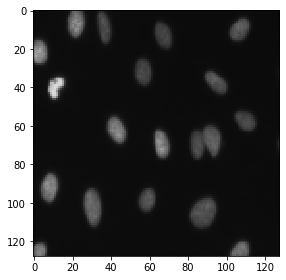

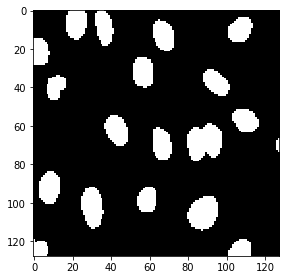

In [9]:
# Check if training data looks all right
if (training):
    ix = random.randint(0, len(train_ids))
    imshow(X_train[ix])
    plt.show()
    imshow(np.squeeze(Y_train[ix]))
    plt.show()

Loss Functions

In [10]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.cast(y_pred > t, dtype = tf.int32)
        score, up_opt = tf.compat.v1.metrics.mean_iou(y_true, y_pred_, 2)
        tf.compat.v1.keras.backend.get_session().run(tf.compat.v1.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return tf.compat.v1.keras.backend.mean(tf.compat.v1.keras.backend.stack(prec), axis=0)

def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true = tf.cast(y_true, dtype = tf.float32)
    y_true_f = tf.compat.v1.keras.backend.flatten(y_true)
    y_pred_f = tf.compat.v1.keras.backend.flatten(y_pred)
    intersection = tf.compat.v1.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.compat.v1.keras.backend.sum(y_true_f) + tf.compat.v1.keras.backend.sum(y_pred_f) + smooth)

# **Model**



In [11]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou, dice_coef])
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
_____________________________________________________________________________________________

# **Training**

In [12]:
# Fit model
if (training):
    earlystopper = EarlyStopping(patience=5, verbose=1)
    checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
    results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                        callbacks=[earlystopper, checkpointer])   

Train on 603 samples, validate on 67 samples
Epoch 1/50
603/603 [==============================] - ETA: 0s - loss: 0.3420 - mean_iou: 0.4475 - dice_coef: 0.5125

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '



Epoch 00001: val_loss improved from inf to 0.24383, saving model to model-dsbowl2018-1.h5
603/603 [==============================] - 8s 14ms/sample - loss: 0.3420 - mean_iou: 0.4475 - dice_coef: 0.5125 - val_loss: 0.2438 - val_mean_iou: 0.5665 - val_dice_coef: 0.6705
Epoch 2/50
592/603 [============================>.] - ETA: 0s - loss: 0.1778 - mean_iou: 0.6144 - dice_coef: 0.7316
Epoch 00002: val_loss improved from 0.24383 to 0.16396, saving model to model-dsbowl2018-1.h5
603/603 [==============================] - 2s 4ms/sample - loss: 0.1782 - mean_iou: 0.6154 - dice_coef: 0.7333 - val_loss: 0.1640 - val_mean_iou: 0.6582 - val_dice_coef: 0.8076
Epoch 3/50
592/603 [============================>.] - ETA: 0s - loss: 0.1455 - mean_iou: 0.6841 - dice_coef: 0.7919
Epoch 00003: val_loss did not improve from 0.16396
603/603 [==============================] - 2s 4ms/sample - loss: 0.1452 - mean_iou: 0.6846 - dice_coef: 0.7909 - val_loss: 0.1662 - val_mean_iou: 0.7048 - val_dice_coef: 0.8148


# **Evaluation**

Predict the masks for training, validation and testing data

In [13]:
# Predict on train, val and test
model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou, 'dice_coef': dice_coef})

if (training):
    preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
    preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
    # Threshold predictions
    preds_train_t = (preds_train > 0.5).astype(np.uint8)
    preds_val_t = (preds_val > 0.5).astype(np.uint8)


preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                      (sizes_test[i][0], sizes_test[i][1]), 
                                      mode='constant', preserve_range=True))
      

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


# **Visualise Training and Validation Results**

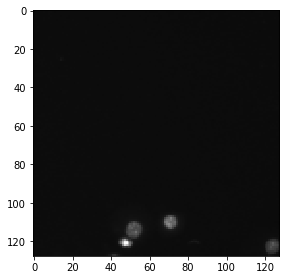

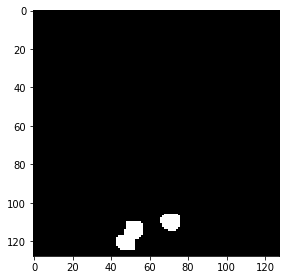

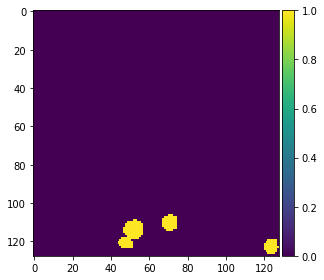

In [14]:
# Perform a sanity check on some random training samples
if (training):
    ix = random.randint(0, len(preds_train_t))
    imshow(X_train[ix])
    plt.show()
    imshow(np.squeeze(Y_train[ix]))
    plt.show()
    imshow(np.squeeze(preds_train_t[ix]))
    plt.show()

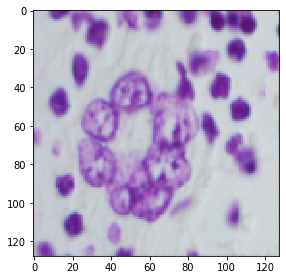

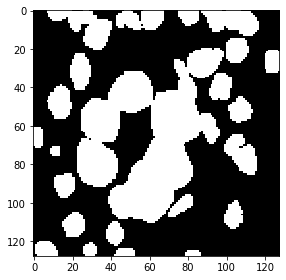

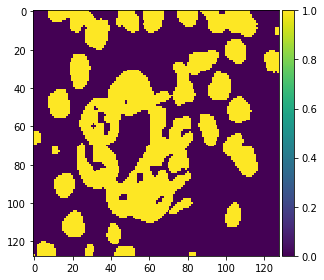

In [15]:
# Perform a sanity check on some random validation samples
if (training):
    ix = random.randint(0, len(preds_val_t))
    imshow(X_train[int(X_train.shape[0]*0.9):][ix])
    plt.show()
    imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
    plt.show()
    imshow(np.squeeze(preds_val_t[ix]))
    plt.show()

# **Storing Predictions**


In [16]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [18]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [19]:
# Perform a sanity check of the run-length encoding format
def check_rles(rles):
    c = 0
    for rle in rles:
        c += 1
        for i in range(0, len(rle)-2, 2):
            if i != len(rle):
                if (rle[i]+rle[i+1] > rle[i+2]):
                    print("BUG {} {}".format(c,i))
                    print("{0} + {1} = {2} > {3}".format(rle[i], rle[i+1], rle[i]+rle[i+1], rle[i+2]))
                    
check_rles(rles)

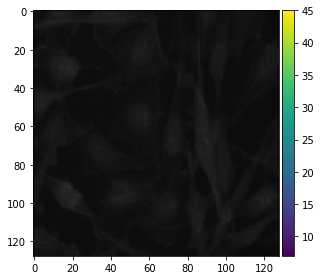

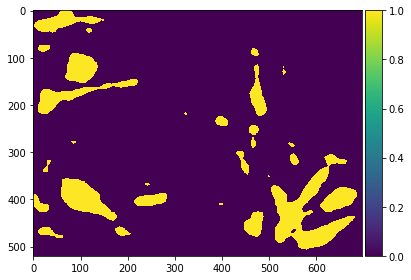

In [20]:
# Perform a sanity check on some random testing samples
imshow(X_test[0])
plt.show()
preds_test_upsampled_0 = (preds_test_upsampled[0] > 0.5).astype(np.uint8)
imshow(np.squeeze(preds_test_upsampled_0))
plt.show()

# **Save results**
After the model has predicted the mask for the testing set, we can save them in a csv file.


In [21]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub-dsbowl2018.csv', index=False)

!cp 'sub-dsbowl2018.csv' '/content/drive/MyDrive/colab/DSB_2018/sub-dsbowl2018.csv'